참고: https://www.kaggle.com/faressayah/credit-card-fraud-detection-anns-vs-xgboost

#**1. 사기 거래 탐지 모델 개발 개요**
## **신용 카드 사기란?**
- **신용 카드 사기**는 누군가가 다른 사람의 신용 카드 또는 계정 정보를 사용하여 **임의로 물건을 구매** 하거나 **현금 서비스를 이용해 자금을 탈취**하는 행위를 말합니다. 
- 신용 카드 사기는 온라인 뿐만아니라 오프라인 매장에서도 발생합니다. 
- 신용 카드의 잠재적인 **사기를 즉각적으로 인식**하고 거래 정지 등의 조치를 빠르게 취하는 것은 해당 금융 기관의 보안 수준과 직결되어 있습니다.
- 또한, 고객의 자산을 보호하기 위해 꼭 필요한 부분이기 때문에 신용 카드회사에서는 앞다투어 **혁신적인 사기탐지 기술을 도입**하기 위한 노력을 하고있습니다. 


## **실습 목표**
- 사기로 판명된 거래에 대한 과거 신용 카드 거래 데이터를 충분히 탐색해서, 데이터 기반의 사기탐지에 대한 인사이트를 찾는것
- 데이터 탐색을 기반으로 부정확한 사기 분류를 최소화하면서 사기성 거래를 100% 탐지하는 기계학습 모형을 개발하는 것

## **샘플 데이터 설명** (creditcard.csv)
- 캐글에서 제공하는 [Credit Card Fraud Detection Dataset](https://www.kaggle.com/aniruddhachoudhury/creditcard-fraud-detection) 데이터입니다. 
- 이 데이터는 2013년 9월 유럽의 신용카드 사용자들의 실제 거래기록으로 총 284,807 건의 거래내역이 제공됩니다. 
- 이 중 492건이 사기거래(Fraud Transaction)이고 사기 거래가 정상 거래에 비해 매우 적은 비율(0.172%)로 "Highly unbalanced'한 특징을 가진 데이터셋입니다.
- 카드 결제 Raw 데이터에는 훨씬 더 많은 차원의 피쳐가 있지만, 샘플 데이터는 '주성분 분석 (PCA)'으로 변환한 28개의 변수(V1 ~ V28)가 제공됩니다. 
- **결제 시간 및 금액**은 PCA로 변환한 값이 아니고 실제 Raw 데이터 입니다.
- 샘플 데이터에는 누락된 값이 없습니다.

## **클래스 불균형이 모델 성능에 영향을 미치는 이유?**
- 거의 대다수가 정상 결제(99.8%)이기 때문에 상당수의 사기 결제 건을 잘못 분류해도 여전히 높은 정확도(Accuracy)를 유지할 수 있습니다. *모든 결제를 정상으로 분류한다면 Accuracy는 99.8%가 됩니다.*
- 하지만, 이러한 분류 모델은 재현율(Recall)이나 정밀도(Precision) 측면의 성능 지표는 좋지 않습니다.

## **불균형 문제를 어떻게 해결할 수 있을까요?**
- 균형 잡힌 데이터 세트에서 모델을 훈련하면 검증 데이터에서도 성능이 좋습니다.
- 그러나 목표는 불균형한 프로덕션 데이터 세트에서 성능을 최적화하는 것입니다. 궁극적으로 프로덕션에서 가장 잘 작동하는 균형을 찾아야합니다.
- 따라서, 이 문제를 해결하기 위해서는 사기 거래는 전체 데이터를 사용하되 (목표하는 False Positive Rate에 도달하기 위해) 필요에 따라 정상 거래는 Under-sampling(=데이터의 일부를 사용)하고, 사기 거래는 SMOTE 등의 기술을 이용해서 Over-sampling합니다.

## **데이터를 탐색하면서 생각해볼 질문**
시간과 거래금액을 제외한 모든 피쳐는 PCA로 변환했기 때문에 변수의 의미를 알 수 없습니다. 하지만, 의미를 알 수 있는 두개의 변수(시간 및 거래 금액)에 대해서는 몇가지 인사이트를 발굴 할 수 있습니다. 
1. 정상과 사기 건의 결제 금액은 얼마나 다를까?
2. 사기 거래가 자주 발생하는 시간대가 있을까?

# **2. 데이터 탐색**
## 필요한 라이브러리 Import

In [29]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm 

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

## Google Drive 연결하기

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 읽기

In [31]:
filepath = '/content/drive/MyDrive/Colab Notebooks/SKKU/data'
fn_csv = os.path.join(filepath, 'creditcard.csv')
df = pd.read_csv(fn_csv)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [39]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

## 변수별 데이터 Type과 NULL값 존재 여부 확인

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## 변수별 기초 통계량 확인

In [42]:
df_stat = df.describe()
# df_stat.to_csv(f"{filepath}/statistics.csv", encoding='utf-8-sig')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


PCA 변환 없이 Raw 데이터 그대로 있는 변수:
- Time
- Amount
- Class (1: fraud, 0: not_fraud)

Text(0, 0.5, 'Frequency')

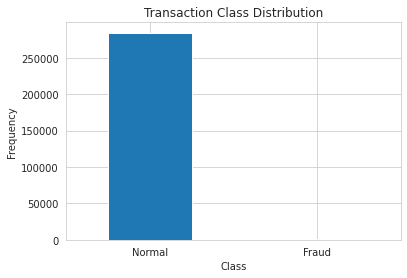

In [7]:
LABELS = ['Normal','Fraud']

count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind='bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [43]:
# df.Class.value_counts()
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

## **데이터 불균형에 주목!**
- 데이터의 Class 분포가 매우 불균형한 것을 알 수 있습니다. 대부분의 카드 결제는 정상이고, 사기는 거의 없습니다. 

- 그러나 우리는 모델이 대부분의 결제가 정상이라고 가정하는 것을 원하지 않으며 모델이 사기 징후를 나타내는 패턴을 감지할 수 있도록 만들어야 합니다.

## **사기와 정상 데이터 나누기**

전체 데이터 세트에서 사기와 정상 거래 데이터로 분리합니다.

In [44]:
df_fraud = df[df['Class']==1]
df_normal = df[df['Class']==0]

print(f"Shape of Fraudulant transactions: {df_fraud.shape}")
print(f"Shape of Non-Fraudulant transactions: {df_normal.shape}")

Shape of Fraudulant transactions: (492, 31)
Shape of Non-Fraudulant transactions: (284315, 31)


## **사기와 정상건의 결제 금액 비교**
다른 거래 클래스에서 사용되는 금액은 얼마나 다른가요?

In [10]:
df_sumry_amount = pd.concat([df_fraud.Amount.describe(), df_normal.Amount.describe()], axis=1)
df_sumry_amount.columns=['Fraud', 'Normal']  ## 컬럼 이름 지정
df_sumry_amount

,Fraud,Normal
count,492.000000,284315.000000
mean,122.211321,88.291022
std,256.683288,250.105092
min,0.000000,0.000000
25%,1.000000,5.650000
50%,9.250000,22.000000
75%,105.890000,77.050000
max,2125.870000,25691.160000


## **사기와 정상건의 결제 시간 비교**

In [11]:
df_sumry_time = pd.concat([df_fraud.Time.describe(), df_normal.Time.describe()], axis=1)
df_sumry_time.columns=['Fraud', 'Normal']
df_sumry_time

,Fraud,Normal
count,492.000000,284315.000000
mean,80746.806911,94838.202258
std,47835.365138,47484.015786
min,406.000000,0.000000
25%,41241.500000,54230.000000
50%,75568.500000,84711.000000
75%,128483.000000,139333.000000
max,170348.000000,172792.000000


## **결제 금액 및 결제 시간 시각화**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


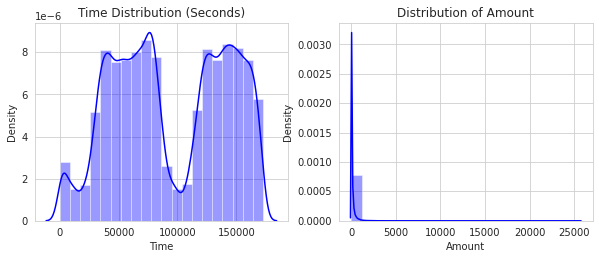

In [12]:
plt.figure(figsize=(10,8))

# plot the time feature
ax1 = plt.subplot(1, 2, 1)
plt.title('Time Distribution (Seconds)')
sns.distplot(df.Time, color='blue', bins=20, ax=ax1);

#plot the amount feature
ax2 = plt.subplot(1, 2, 2)
plt.title('Distribution of Amount')
sns.distplot(df.Amount, color='blue', bins=20, ax=ax2);

## **사기와 정상건의 결제 시간 분포 비교**

결제 시간의 분포를 보면, 결제 시간이 골고루 분포되기 보다는 특정 시간대에 결제가 집중되어 있음을 알 수 있습니다. 


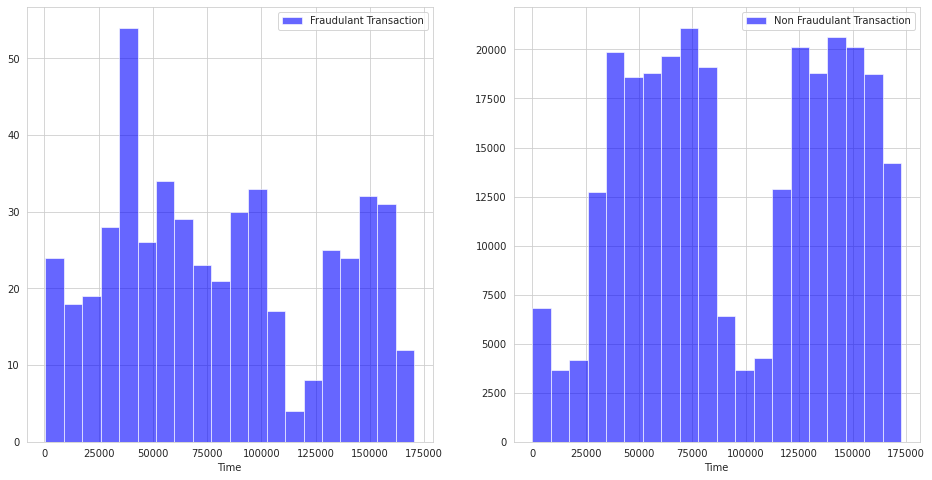

In [13]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
df[df.Class == 1].Time.hist(bins=20, color='blue', alpha=0.6, label="Fraudulant Transaction")
plt.xlabel("Time")
plt.legend()

plt.subplot(1, 2, 2)
df[df.Class == 0].Time.hist(bins=20, color='blue', alpha=0.6, label="Non Fraudulant Transaction")
plt.xlabel("Time")
plt.legend()

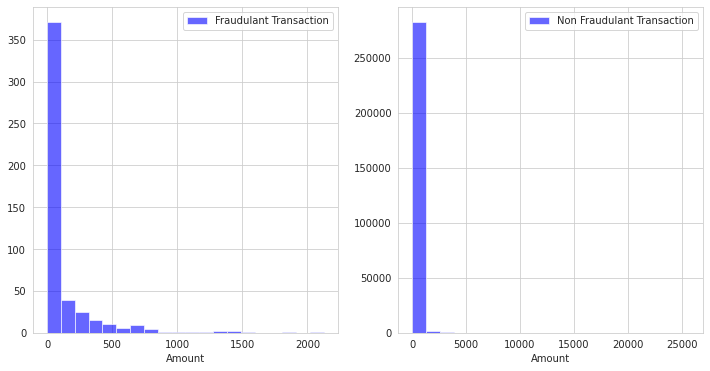

In [45]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df[df.Class == 1].Amount.hist(bins=20, color='blue', alpha=0.6, label="Fraudulant Transaction")
plt.xlabel("Amount")
plt.legend()

plt.subplot(1, 2, 2)
df[df.Class == 0].Amount.hist(bins=20, color='blue', alpha=0.6, label="Non Fraudulant Transaction")
plt.xlabel("Amount")
plt.legend()

## **전체 데이터의 분포**

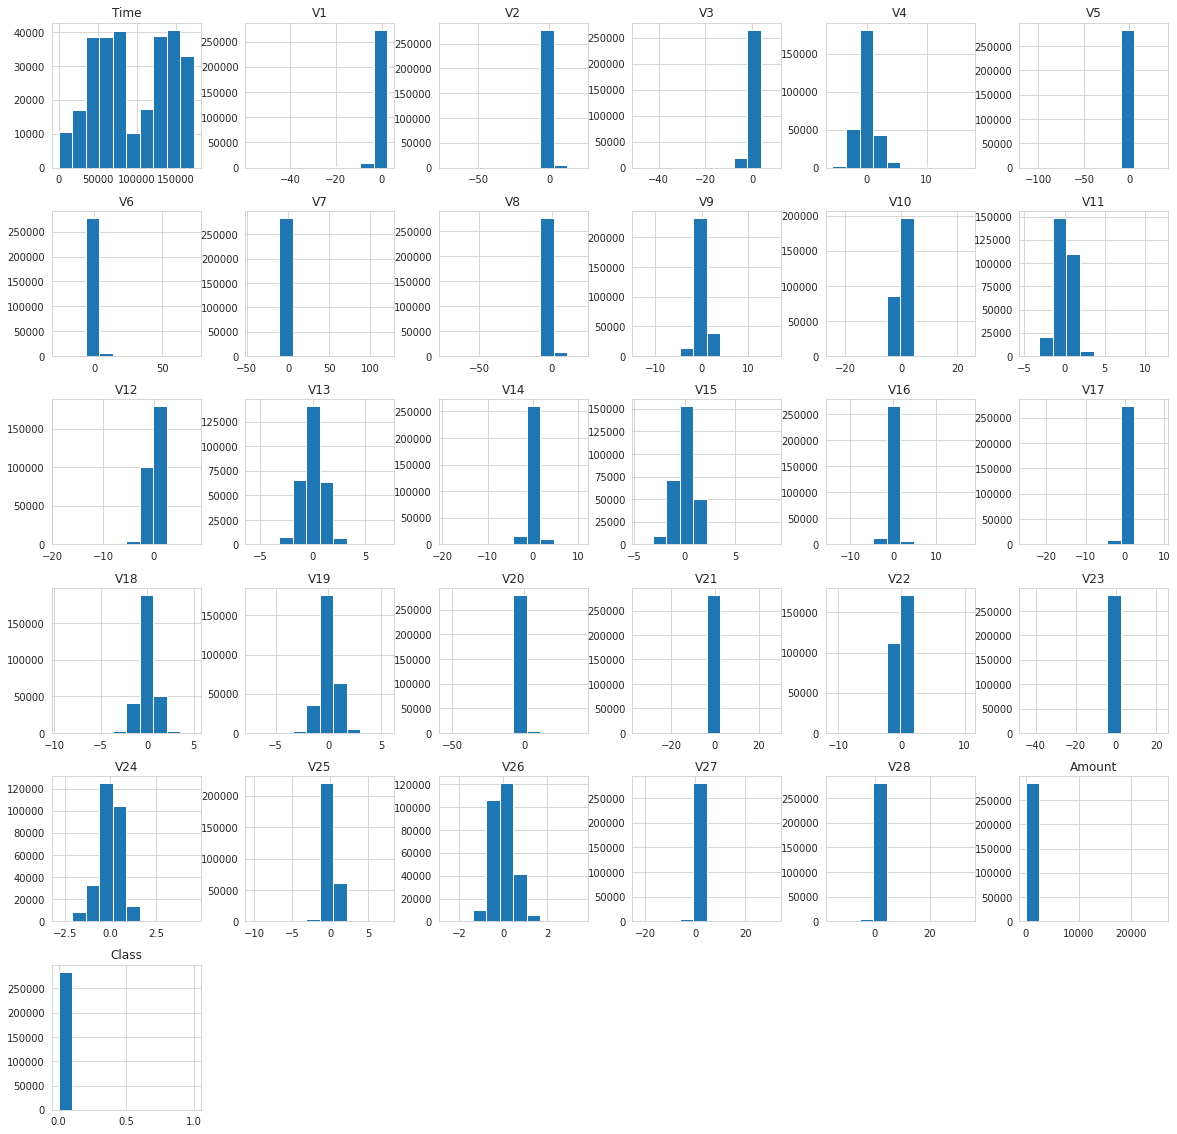

In [46]:
df.hist(figsize=(20, 20));

## **변수간 상관성 확인**

In [47]:
df.corr()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,...,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,...,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,...,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,...,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,...,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,...,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,...,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,...,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,...,1.936953e-16,-7.071869e-16,-5.214137e-16,-1.430343e-16,6.757763e-16,-7.888853e-16,-6.709655e-17,1.110541e-15,-0.044246,-0.097733


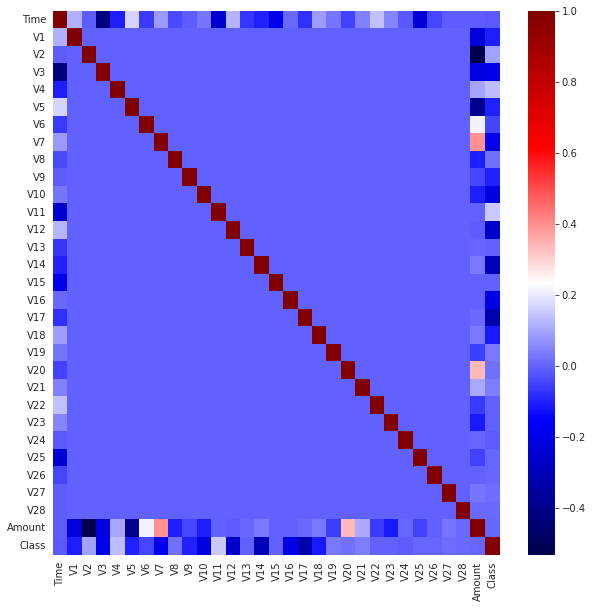

In [48]:
# heatmap to find any high correlations

plt.figure(figsize=(10,10))
sns.heatmap(data=df.corr(), cmap="seismic")
plt.show();

- 높은 상관성을 보이는 변수 쌍은 다음과 같습니다.  
  ㄴ Time & V3 (-0.42)  
  ㄴ Amount & V2 (-0.53)  
  ㄴ Amount & V4 (0.4)  

- 일부 변수에서 높은 상관관계가 보여지긴 하지만 다중공선성(multicollinearity) 위험을 감수 할 것으로 예상되지는 않습니다.

- 또한, 상관성 행렬을 보면 V1~V28 PCA 구성 요소 중 어느 것도 서로 상관 관계가 없음을 알 수 있습니다. 

- Class와 V구성 요소간에 양의 상관 관계 또는 음의 상관 관계가 있습니다. 하지만 Class는 시간 및 결제 금액과는 상관 관계가 없는 것으로 보입니다.

# **3. 데이터 전처리**
`Time`와 `Amount` 변수도 다른 피쳐와 마찬가지로 정규화 해야 합니다.


## **3.1 Train, validation, test dataset**


In [17]:
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df.Class

# (Train, Validation), Test 데이터 나누기 (Train : Test = 7 : 3)
X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_v, y_train_v, test_size=0.2, random_state=1)


# 각 데이터셋의 크기 확인
print(f"TRAINING: X_train: {X_train.shape}, y_train: {y_train.shape}\n{'-'*60}")
print(f"VALIDATION: X_validate: {X_validate.shape}, y_validate: {y_validate.shape}\n{'-'*60}")
print(f"TESTING: X_test: {X_test.shape}, y_test: {y_test.shape}")

TRAINING: X_train: (159491, 30), y_train: (159491,)
------------------------------------------------------------
VALIDATION: X_validate: (39873, 30), y_validate: (39873,)
------------------------------------------------------------
TESTING: X_test: (85443, 30), y_test: (85443,)


## **3.2 피쳐값 정규화**
- MinMaxScaler: 각각의 변수를 0-1 범위가 되도록 변환함
- StandardScaler: 각각의 변수를 평균이 0, 표준편차가 1이 되도록 변환함

In [18]:
from sklearn.preprocessing import StandardScaler 

# 표준 졍규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

# Class 구성비율
w_p = np.round(y_train.value_counts()[0] / len(y_train), 4)
w_n = np.round(y_train.value_counts()[1] / len(y_train), 4)

print(f"Fraudulant transaction weight: {w_n}")
print(f"Non-Fradulant transaction weights: {w_p}")

Fraudulant transaction weight: 0.0018
Non-Fradulant transaction weights: 0.9982


## **3.3 모델 성능 출력 함수 정의**

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

def model_report(y_real, y_pred):
    clf_report = pd.DataFrame(classification_report(y_real, y_pred, output_dict=True)).iloc[:,1]
    clf_report.drop('support', inplace=True)
    clf_report['accuracy'] = accuracy_score(y_real, y_pred)
    
    return clf_report

# **4. 모형 개발(1차)**

Card FDS 시스템을 개발하기 위해서 RandomForest, XGBoost, Neural Network 총 세가지 방법으로 모델을 만들어 보고 성능을 비교해 보겠습니다.  

모델을 개발하기에 앞서 RandomForest의 원리가 되는 **배깅(bagging)**과 XGBoost의 원리가 되는 **부스팅(boosting)**에 대해서 간단하게 설명해 드릴께요. 배깅과 부스팅은 모두 앙상블 모형이라고 불립니다. 하지만, 아래 그림에서와 같이 앙상블을 구성하는 모델을을 학습할때 데이터를 샘플링(sampling)하는 방법과 결과를 도출하는 방법에서 차이가 있습니다.


### **A. 데이터 샘플링 방법**
- 배깅은 모형 학습에 필요한 데이터를 동일한 가중치로 추출
- 부스팅은 모형 학습에 필요한 데이터를 추출할때 분류가 잘 안되는 데이터에 더 큰 가중치를 부여하여 추출
![image](https://drive.google.com/uc?export=view&id=1dN8gO6YXDiJWWFb1U_qRq8gfjfIz5IvG)

### **B. 모형 학습 방법**
- 배깅은 각각 독립적으로 샘플링된 데이터를 독립적으로 학습하고, 최종 결과값을 앙상블 할때도 샘플간 동일한 가중치를 부여함
- 부스팅은 최초 샘플링된 데이터에서 학습을 한 이후에 학습이 잘 진행되지 않은 데이터에 가중치를 두어 샘플링하고, 최종 결과값을 앙상블 할때는 성능이 좋은 모델에 가중치를 부여함.
![image](https://drive.google.com/uc?export=view&id=1gnWLrZ5pHbzFAB2LLaRe-8Eo2vA_j3EQ)


## **4.1. RandomForest 모델**

In [58]:
model_rf.feature_importances_

array([0.0123026 , 0.00562755, 0.02307029, 0.01548463, 0.02990436,
       0.00461659, 0.01096955, 0.03586236, 0.01169441, 0.03114573,
       0.02837449, 0.0819447 , 0.08931378, 0.01744838, 0.08098236,
       0.0080727 , 0.08157373, 0.29116336, 0.02253364, 0.00628728,
       0.01845541, 0.01038862, 0.00306388, 0.0048499 , 0.01381972,
       0.01938576, 0.00542809, 0.01129536, 0.00792308, 0.01701769])

In [50]:
print("-"*50)


--------------------------------------------------


## **4.2. XGBoost 모델**

In [51]:
from xgboost import XGBClassifier

# Modeling and Training
model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_train,  y_train, 
              eval_set=[(X_validate, y_validate)], 
              early_stopping_rounds = 50,
              verbose=True)

# Predict
y_pred = model_xgb.predict(X_test)
y_real = y_test

# Model report
report_xbg = model_report(y_real, y_pred)
report_xbg.name = "XGBoost (7:3)"
print("-"*20)
print(report_xbg)
print("-"*20)


[0]	validation_0-error:0.000878
Will train until validation_0-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.000702
[2]	validation_0-error:0.000527
[3]	validation_0-error:0.000527
[4]	validation_0-error:0.000527
[5]	validation_0-error:0.000527
[6]	validation_0-error:0.000527
[7]	validation_0-error:0.000527
[8]	validation_0-error:0.000527
[9]	validation_0-error:0.000527
[10]	validation_0-error:0.000527
[11]	validation_0-error:0.000527
[12]	validation_0-error:0.000527
[13]	validation_0-error:0.000527
[14]	validation_0-error:0.000527
[15]	validation_0-error:0.000527
[16]	validation_0-error:0.000527
[17]	validation_0-error:0.000527
[18]	validation_0-error:0.000527
[19]	validation_0-error:0.000527
[20]	validation_0-error:0.000527
[21]	validation_0-error:0.000527
[22]	validation_0-error:0.000527
[23]	validation_0-error:0.000702
[24]	validation_0-error:0.000702
[25]	validation_0-error:0.000702
[26]	validation_0-error:0.000702
[27]	validation_0-error:0.000702
[28]	validation_0-er

## **4.3. Neural Network 모델**

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# import tensorflow.keras.backend as K
# K.clear_session()

# Input and Output data size
n_inputs = X_train.shape[1]
n_output = 2

# Neural Network 모형
keras.backend.clear_session()
model_nn = keras.Sequential([
    keras.layers.Dense(64, activation='tanh', input_shape=(X_train.shape[-1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(n_output, activation='softmax'),                     
])

model_nn.compile(optimizer = keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1984      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 4,626
Trainable params: 4,626
Non-trainable params: 0
_________________________________________________________________


In [52]:
# 출력값을 2-columns 형태로 변형
y_train2=y_train.to_frame()
y_train2.rename(columns={"Class":"fraud"}, inplace=True)
y_train2['normal'] = 1-y_train2['fraud']
y_train2 = np.array(y_train2[['normal','fraud']].values.tolist())

y_validate2=y_validate.to_frame()
y_validate2.rename(columns={"Class":"fraud"}, inplace=True)
y_validate2['normal'] = 1-y_validate2['fraud']
y_validate2 = np.array(y_validate2[['normal','fraud']].values.tolist())


# Train
model_nn.fit(
   X_train, y_train2,
   batch_size=100,
   validation_data = (X_validate, y_validate2),
   epochs=10
)

# Predict
y_pred = model_nn.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_real = y_test 

# Model report
report_nn = model_report(y_real, y_pred)
report_nn.name='Neural Network (7:3)'

print("-"*20)
print(report_nn)
print("-"*20)

Epoch 1/10
228/228 [==============================] - 1s 3ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 6.2301e-04 - val_accuracy: 1.0000
Epoch 2/10
228/228 [==============================] - 1s 3ms/step - loss: 9.0606e-04 - accuracy: 0.9998 - val_loss: 2.9107e-04 - val_accuracy: 1.0000
Epoch 3/10
228/228 [==============================] - 1s 3ms/step - loss: 5.5282e-04 - accuracy: 0.9998 - val_loss: 5.6173e-04 - val_accuracy: 0.9996
Epoch 4/10
228/228 [==============================] - 1s 3ms/step - loss: 3.5769e-04 - accuracy: 1.0000 - val_loss: 3.7262e-04 - val_accuracy: 0.9998
Epoch 5/10
228/228 [==============================] - 1s 3ms/step - loss: 2.3179e-04 - accuracy: 1.0000 - val_loss: 3.0587e-04 - val_accuracy: 1.0000
Epoch 6/10
228/228 [==============================] - 1s 3ms/step - loss: 1.0718e-04 - accuracy: 1.0000 - val_loss: 2.9416e-04 - val_accuracy: 0.9998
Epoch 7/10
228/228 [==============================] - 1s 3ms/step - loss: 6.5896e-05 - accuracy: 1.0000 

## **4.4. 모델 비교**
위에서 3가지 모델을 학습한 결과는 아래와 같습니다. 물론, 하이퍼 파라미터들을 어떻게 변경시키느냐에 따라 많이 바뀌겠지만 개념적으로 접근해 보겠습니다.

| No |   Model     | Precision | Recall | F1-score | Accuracy | train-test rate
| ------------    | --------------- | --------------- |  ---|---| ---|  ---|
| 1 | RandomForest   | 0.886957 | 0.755556 | 0.816000 |  0.999462| 7 : 3 |
| 2 | XGBoost        | 0.872727 | 0.711111 | 0.783673  | 0.999380| 7 : 3  |
| 3 | Neural Network | 0.890909 | 0.725926 | 0.800000 | 0.999427| 7 : 3  |

세 모델 모두 F1-score가 80% 이상으로 나름대로 좋은 성능을 보여주고 있습니다. 

훈련데이터에 나름 사기 라벨이 어느정도 충분이 있었기 때문에 모형의 종류와 상관없이 학습을 어느정도 잘 수행했다고 할 수 있습니다. 

모형들이 서로 비슷비슷한 성능을 보일때는 어느 하나의 모형을 선택해서 서비스에 적용하기 보다는 성능이 괜찮은 모형 여러개의 출력값을 앙상블 평균하여 서비스에 적용하는 경우가 많이 있습니다. 

만약, 학습 데이터의 양이 극히 적으면 과연 학습이 잘 될까요?  

위와 완전히 동일한 모델로 train-test 비율이 0.5:0.95로 다시 학습해 보면 아래와 같이 나타납니다.


| No |   Model     | Precision | Recall | F1-score | Accuracy | train-test rate
| ------------    | --------------- | --------------- |  ---| ---|  ---|  ---|
| 1 | RandomForest   | 0.925110 | 0.443038 | 0.599144  |  0.998961| 0.5 : 0.95 |
| 2 | XGBoost        | 0.870722 | 0.483122 | 0.621438   | 0.998969  | 0.5 : 0.95  |
| 3 | Neural Network | 0.919598 | 0.386076 | 0.543834 |  0.998865 | 0.5 : 0.95  |


RandomForest와 Neural Network의 경우 정확도(precision)은 증가함. 하지만, 세 모형 모두 재현율(recall)이 30%p정도 내려갔으며, 이로인해서 F1-score가 상당히 많이 떨어졌습니다. 



사기 관련 모델은 학습 데이터가 급격하게 적은 경우가 많기 때문에, 이러한 경우에도 잘 작동할 수 있는 모형이 필요합니다. 따라서, 학습 데이터가 적은 경우에도 적용 가능한 모델을 개발할 필요가 있습니다.

# **5. Autoencoder 기반의 사기탐지 모형개발**

이번에는 신경망을 이용한 오토인코더(Autoencoder)로 학습을 시켜보고자 합니다. 

오토인코더를 간단하게 설명하자면 신경망 네트워크를 조금 특별한 형태의 구조를 갖도록 구성하는 것입니다. 입력 데이터와 출력 데이터의 사이즈(size)를 같게 하고 중간에 레이어를 넣어서 데이터를 원상복귀하게 만드는 구조입니다.

![image](https://drive.google.com/uc?export=view&id=1r3G3c9VyhuovFyi4F815qTlyeIkzOPKL)

위의 그림과 같이 **인코더(encoder)와 디코더(decoder)를 통해 마치 압축했다가 압축해제하며 결과가 같도록 학습하**는 것입니다. 중간에 있는 레이어를 보통 Latent vector라고 표현합니다. 마치 입력데이터를 가지고 신경망에서 "알아서 vector로 표현해봐"라고 하는 느낌입니다.

이 오토인코더에 정상 거래 데이터만을 학습시키면 정상 거래만 원상복구하는 패턴을 인지하는 모델을 생성하고 이 모델에 정상 거래를 넣으면 잘 원상복구 할 것이고, 사기 거래는 원상복구가 잘 안되는 현상이 발생할 것입니다. 

그 다음 Neural Network 모델을 이용하여 정상거래와 사기거래가 오토인코더에 넣었을 때 값을 기반으로 분류할 수 있도록 구성할 것입니다. 

먼저 적은 양의 학습데이터만을 가지기 위해 train-test 비율을 1:9로 생성하겠습니다.

## **5.1. Train, validation, test dataset**


In [53]:
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df.Class

# Train, Validation, Test 데이터 나누기 (Train : Test = 1 : 9)
X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, test_size=0.9, random_state=1)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_v, y_train_v, test_size=0.2, random_state=1)

# 표준 졍규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)


# 각 데이터셋의 크기 확인
print(f"TRAINING: X_train: {X_train.shape}, y_train: {y_train.shape}\n{'-'*60}")
print(f"VALIDATION: X_validate: {X_validate.shape}, y_validate: {y_validate.shape}\n{'-'*60}")
print(f"TESTING: X_test: {X_test.shape}, y_test: {y_test.shape}")

TRAINING: X_train: (22784, 30), y_train: (22784,)
------------------------------------------------------------
VALIDATION: X_validate: (5696, 30), y_validate: (5696,)
------------------------------------------------------------
TESTING: X_test: (256327, 30), y_test: (256327,)


## **5.2. Encoder-Decoder** 


In [54]:
# K.clear_session()

n_inputs = X_train.shape[1]
n_outputs = 2
n_latent = 64

# Input
inputs = keras.layers.Input(shape=(n_inputs, ))
x = keras.layers.Dense(128, activation='tanh')(inputs)
# x = keras.layers.Dense(64, activation='tanh')(x)
latent = keras.layers.Dense(n_latent, activation = 'tanh')(x)

# Encoder
encoder = keras.models.Model(inputs, latent, name='encoder')
encoder.summary()

latent_inputs = keras.layers.Input(shape=(n_latent, ))
x = keras.layers.Dense(128, activation='tanh')(latent_inputs)
outputs = keras.layers.Dense(n_inputs, activation='sigmoid')(x)

# Decoder
decoder = keras.models.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_11 (Dense)            (None, 128)               3968      
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
Total params: 12,224
Trainable params: 12,224
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_13 (Dense)            (None, 12

## **5.3. Model Training**
**정상 결제건만 이용해서 Auto-Encoder를 훈련시킨다.**


In [55]:
X_train_norm = X_train[y_train==0]
X_validate_norm = X_validate[y_validate==0]

# Auto-Encoder Model
model_ae = keras.models.Model(inputs, decoder(encoder(inputs)))
model_ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mae')

# Train
model_ae.fit(
   X_train_norm, X_train_norm,
   validation_data = (X_validate_norm, X_validate_norm),
   batch_size=100,
   epochs=50
)

Epoch 1/50
228/228 [==============================] - 1s 3ms/step - loss: 0.5508 - val_loss: 0.4770
Epoch 2/50
228/228 [==============================] - 1s 3ms/step - loss: 0.4578 - val_loss: 0.4535
Epoch 3/50
228/228 [==============================] - 1s 3ms/step - loss: 0.4434 - val_loss: 0.4449
Epoch 4/50
228/228 [==============================] - 1s 3ms/step - loss: 0.4365 - val_loss: 0.4394
Epoch 5/50
228/228 [==============================] - 1s 3ms/step - loss: 0.4319 - val_loss: 0.4361
Epoch 6/50
228/228 [==============================] - 1s 3ms/step - loss: 0.4288 - val_loss: 0.4335
Epoch 7/50
228/228 [==============================] - 1s 3ms/step - loss: 0.4267 - val_loss: 0.4317
Epoch 8/50
228/228 [==============================] - 1s 3ms/step - loss: 0.4251 - val_loss: 0.4306
Epoch 9/50
228/228 [==============================] - 1s 3ms/step - loss: 0.4240 - val_loss: 0.4295
Epoch 10/50
228/228 [==============================] - 1s 3ms/step - loss: 0.4229 - val_loss: 0.4284

## **5.4 학습됩 Latent Vector로 정상/사기 분류 모델 생성**


In [56]:
# 출력값을 2-columns 형태로 변형
y_train2 = y_train.to_frame()
y_train2.rename(columns={"Class":"fraud"}, inplace=True)
y_train2['normal'] = 1-y_train2['fraud']
y_train2 = np.array(y_train2[['normal','fraud']].values.tolist())

y_validate2 = y_validate.to_frame()
y_validate2.rename(columns={"Class":"fraud"}, inplace=True)
y_validate2['normal'] = 1-y_validate2['fraud']
y_validate2 = np.array(y_validate2[['normal','fraud']].values.tolist())

# Build Model
model_hybrid = keras.Sequential([
    keras.layers.Dense(64, activation='tanh', input_dim=n_latent),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(n_outputs, activation = 'softmax')
])

model_hybrid.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model_hybrid.summary()

# Train
encoded_train = encoder.predict(X_train)
encoded_validate = encoder.predict(X_validate)

model_hybrid.fit(
   encoded_train, y_train2,
   validation_data = (encoded_validate, y_validate2),
   batch_size=100,
   epochs=10
)


# Predict
encoded_test = encoder.predict(X_test)
y_pred = model_hybrid.predict(encoded_test)
y_real = y_test 

# Model report
y_pred = y_pred.argmax(axis=1)
report_hybrid = model_report(y_real, y_pred)
report_hybrid.name='AutoEncoder + Neural Network (1:9)'

print("-"*20)
print(report_hybrid)
print("-"*20)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 2)                 66        
                                                                 
Total params: 6,306
Trainable params: 6,306
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
228/228 [==============================] - 1s 3ms/step - loss: 0.0622 - accuracy: 0.9965 - val_loss: 0.0038 - val_accuracy: 0.9991
Epoch 2/10
228/228 [==============================] - 1s 2ms/step - loss: 0.0054 - accuracy: 0.9991 - val_loss: 0.0021 - val_accuracy: 0.9995
Epoch 3/10
228/228 [============

**클래스 불균형이 심각한 데이터에서, Auto-Encoder를 이용하면 비교적 적은 학습데이터로도 F1-score가 80% 달하는 좋은 모델**을 만들 수 있습니다.

# **6. 모델 비교**

- Neural Network, XGBoost, RandomForest, Hybrid (Auto-Encoder/Neural Network) Model 네개의 모델에 대해서 F1-score를 비교했습니다. 
- Neural Network, XGBoost, RandomForest의 경우에는 학습 데이터와 테스트 데이터의 구성비가 7:3으로 학습 데이터의 양이 충분한 상태에서 훈련한 모델이고, Hybrid Model의 경우에는 학습 데이터와 테스트 데이터의 구성비가 1:9로 학습 데이터의 양이 충분하지 않은 상태에서 훈련한 모델입니다. 

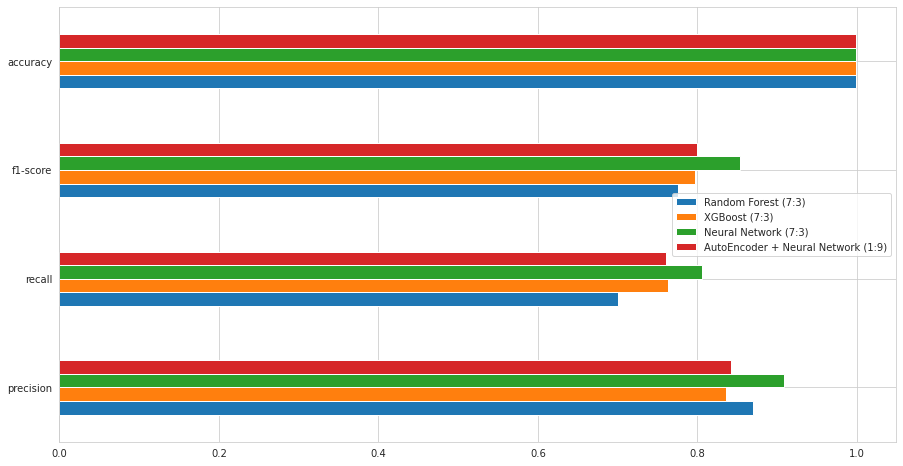

In [57]:
report_df = pd.concat([report_rf, report_xbg, report_nn, report_hybrid], axis=1)
report_df.plot(kind='barh', figsize=(15,8))